# ECG Inspection
This notebook processes the ECG data from the new scan and displays the ECG traces with detected R-peaks.
Visually verify that the R-peak detection is accurate.
In the future, additional functionality for advanced ECG analysis can be integrated.

### Loading packages and data

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import utils.data_ingestion as di
import utils.ecg as ecg

def load_config(config_file="config.yaml"):
    with open(config_file, "r") as f:
        config = yaml.safe_load(f)
    return config

config = load_config()

# Set the file paths (or load from a temporary config file if you wish)
twix_file = config["data"]["twix_file"]
dicom_folder = config["data"]["dicom_folder"]

# Read TWIX file and extract k-space data
scans = di.read_twix_file(twix_file, include_scans=[-1], parse_pmu=False)

Software version: VD/VE (!?)

Scan  1


100%|██████████| 287M/287M [00:00<00:00, 1.15GB/s]

Read 1 scans from 20250307_JM/raw/meas_MID00115_FID27380_Cor_250306_2.dat


### Extracting and analyzing ECG

Extracted ICE parameter data shape: (12800, 3)
Extracted image data shape: (12800, 30, 256)


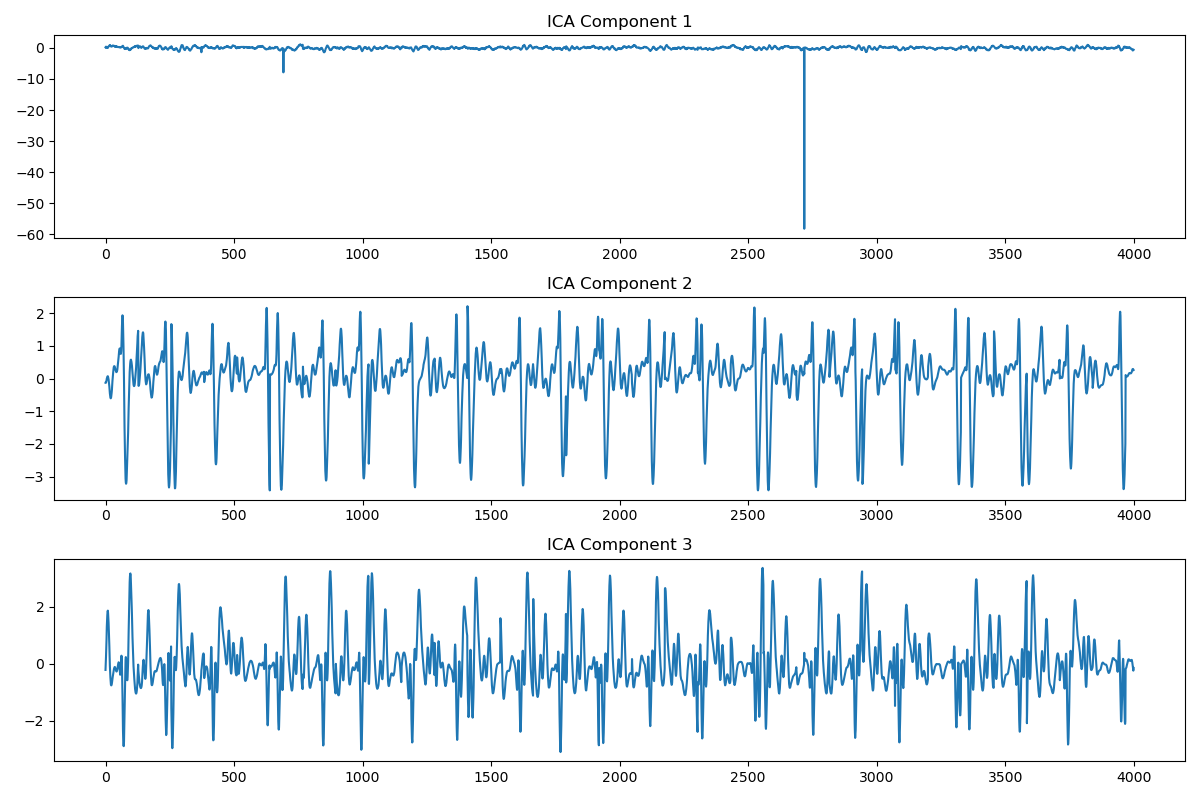

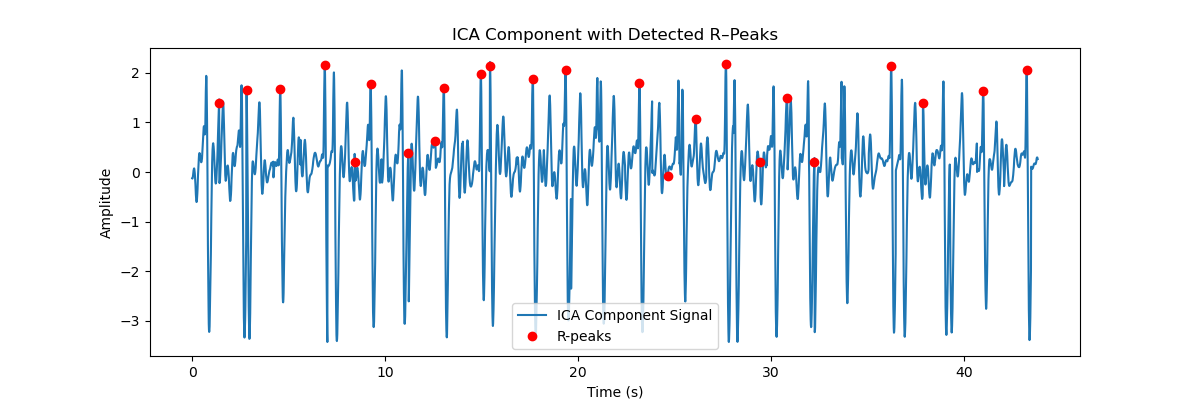

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.decomposition import FastICA

ecg_columns = np.s_[18:21]
ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)

ecg_data = (ecg_data - np.mean(ecg_data, axis=0)) / np.std(ecg_data, axis=0) # Normalize ECG signals

framerate, frametime = di.get_dicom_framerate(dicom_folder)

kspace = di.extract_image_data(scans)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]

# For ECG processing, you need the sampling frequency.
fs = framerate * n_phase_encodes_per_frame

# --- Assume ecg_data and fs are already loaded in the notebook ---
# For demonstration, we'll use a subset of the data (e.g. first 4000 samples)
ecg_data_ica = ecg_data[:4000]  # ecg_data should be a 2D array (n_samples, n_channels)

# Perform FastICA (we use as many components as channels)
ica = FastICA(n_components=ecg_data_ica.shape[1], random_state=42)
X_ica = ica.fit_transform(ecg_data_ica)  # shape: (n_samples, n_components)

# Plot all ICA components
plt.figure(figsize=(12, 8))
for i in range(X_ica.shape[1]):
    plt.subplot(X_ica.shape[1], 1, i + 1)
    plt.plot(X_ica[:, i])
    plt.title(f"ICA Component {i+1}")
    plt.tight_layout()
plt.show()

# Choose a component for R-peak detection (adjust index as needed)
component_to_use = 1
ica_signal = X_ica[:, component_to_use]

# Process the selected component to detect R-peaks using NeuroKit2
processed, info = nk.ecg_process(ica_signal, sampling_rate=fs)
r_peaks_ica = info["ECG_R_Peaks"]

# Plot the selected ICA component with detected R-peaks
t = np.arange(len(ica_signal)) / fs
plt.figure(figsize=(12, 4))
plt.plot(t, ica_signal, label="ICA Component Signal")
plt.plot(t[r_peaks_ica], ica_signal[r_peaks_ica], "ro", label="R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("ICA Component with Detected R–Peaks")
plt.legend()
plt.show()

Extracted ICE parameter data shape: (12800, 3)
Extracted image data shape: (12800, 30, 256)


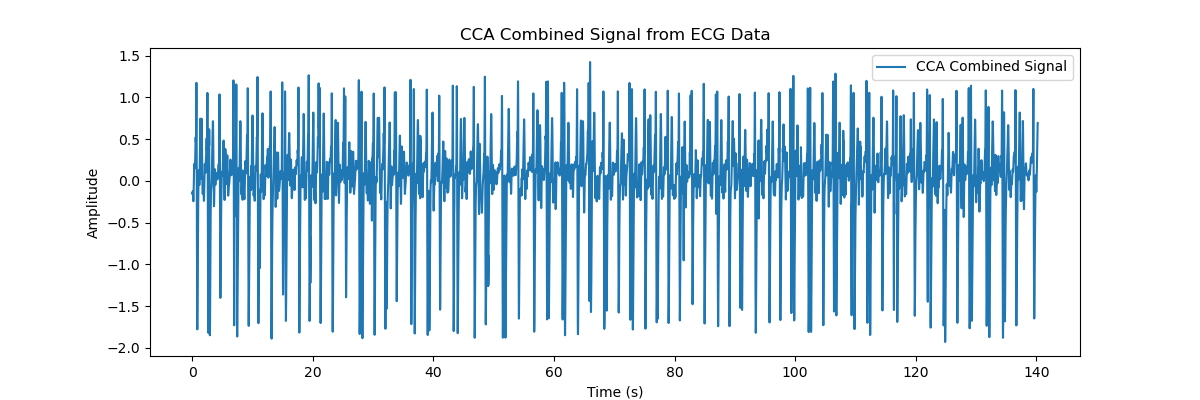

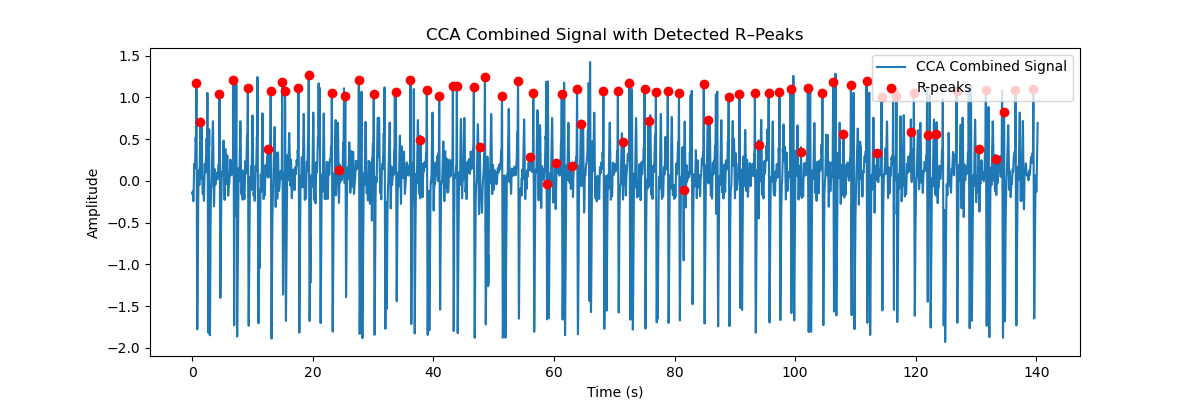

In [6]:
from sklearn.cross_decomposition import CCA
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
from sklearn.decomposition import FastICA

ecg_columns = np.s_[18:21]
ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)

ecg_data = (ecg_data - np.mean(ecg_data, axis=0)) / np.std(ecg_data, axis=0) # Normalize ECG signals

framerate, frametime = di.get_dicom_framerate(dicom_folder)

kspace = di.extract_image_data(scans)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]

# For ECG processing, you need the sampling frequency.
fs = framerate * n_phase_encodes_per_frame

# --- Assume ecg_data and fs are already loaded in the notebook ---
# Here, ecg_data is a 2D array (n_samples, n_channels)
# We create two views by using a fixed time-lag.
lag = 5  # Adjust lag as needed (in number of samples)
if ecg_data.shape[0] <= lag:
    raise ValueError("Not enough samples for CCA with the specified lag.")

# Create two views: one original and one shifted by 'lag' samples
X_view = ecg_data[:-lag]
Y_view = ecg_data[lag:]

# Perform CCA with one component (you can try more if desired)
cca = CCA(n_components=3)
cca.fit(X_view, Y_view)
X_c, Y_c = cca.transform(X_view, Y_view)

# Combine the two canonical variates (here we simply average them)
combined_signal = (X_c[:, 0].flatten() + Y_c[:, 0].flatten()) / 2

# Plot the combined CCA signal
t = np.arange(len(combined_signal)) / fs
plt.figure(figsize=(12, 4))
plt.plot(t, combined_signal, label="CCA Combined Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("CCA Combined Signal from ECG Data")
plt.legend()
plt.show()

# Perform R-peak detection on the CCA combined signal using NeuroKit2
processed, info = nk.ecg_process(combined_signal, sampling_rate=fs)
r_peaks_cca = info["ECG_R_Peaks"]

# Plot the CCA signal with detected R-peaks
plt.figure(figsize=(12, 4))
plt.plot(t, combined_signal, label="CCA Combined Signal")
plt.plot(t[r_peaks_cca], combined_signal[r_peaks_cca], "ro", label="R-peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("CCA Combined Signal with Detected R–Peaks")
plt.legend()
plt.show()

In [ ]:
ecg_columns = np.s_[18:21]
ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)

ecg_data = (ecg_data - np.mean(ecg_data, axis=0)) / np.std(ecg_data, axis=0) # Normalize ECG signals

framerate, frametime = di.get_dicom_framerate(dicom_folder)

kspace = di.extract_image_data(scans)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]

# For ECG processing, you need the sampling frequency.
fs = framerate * n_phase_encodes_per_frame

# ecg.plot_ecg_signals(ecg_data, fs, mode="separate")

ecg_data = ecg_data[:4000]

def estimate_sigma_by_median(data, subsample_size=1000, seed=42):
    """
    Estimate a good sigma for RBF kernel
    by computing the median distance among a subsample of data.
    data shape: (n_samples, n_features).
    """
    rng = np.random.RandomState(seed)
    n = data.shape[0]

    # Subsample
    idx = rng.choice(n, size=min(subsample_size, n), replace=False)
    subset = data[idx]

    # Compute pairwise distances
    # (You can use scipy.spatial.distance.cdist if you prefer)
    dists = []
    for i in range(subset.shape[0]):
        # Euclidean distance from subset[i] to all others in the subset
        diff = subset - subset[i]
        dist_i = np.sqrt(np.sum(diff**2, axis=1))
        dists.extend(dist_i.tolist())

    median_dist = np.median(dists)
    
    # Return sigma = median_dist, or you might do /np.sqrt(2)
    return median_dist

# Example usage:
sigma_guess = estimate_sigma_by_median(ecg_data)
print(f"Estimated sigma via median distance: {sigma_guess}")

kpca_model, X_kpca = ecg.ecg_perform_kernel_pca(ecg_data, sigma=sigma_guess)

ecg.plot_ecg_components_time_series_and_fft(X_kpca, fs, n_components=5)

X_kpca = X_kpca[:, [0]]

# Detect R-peaks
r_peaks_list = ecg.detect_r_peaks(X_kpca, fs)
# Compute average heart rate (for information)
hr = ecg.compute_average_heart_rate(r_peaks_list, fs)
print(f"Average heart rate: {hr:.2f} BPM")

# Plot ECG signals with R-peaks
ecg.plot_ecg_signals(X_kpca, fs, r_peaks_list, mode="separate")

Extracted ICE parameter data shape: (12800, 3)
Extracted image data shape: (12800, 30, 256)
Estimated sigma via median distance: 1.699085101778429


TypeError: ecg_perform_pca() got an unexpected keyword argument 'sigma'

Extracted ICE parameter data shape: (4800, 3)
Extracted image data shape: (4800, 30, 256)
Average heart rate: 133.20 BPM


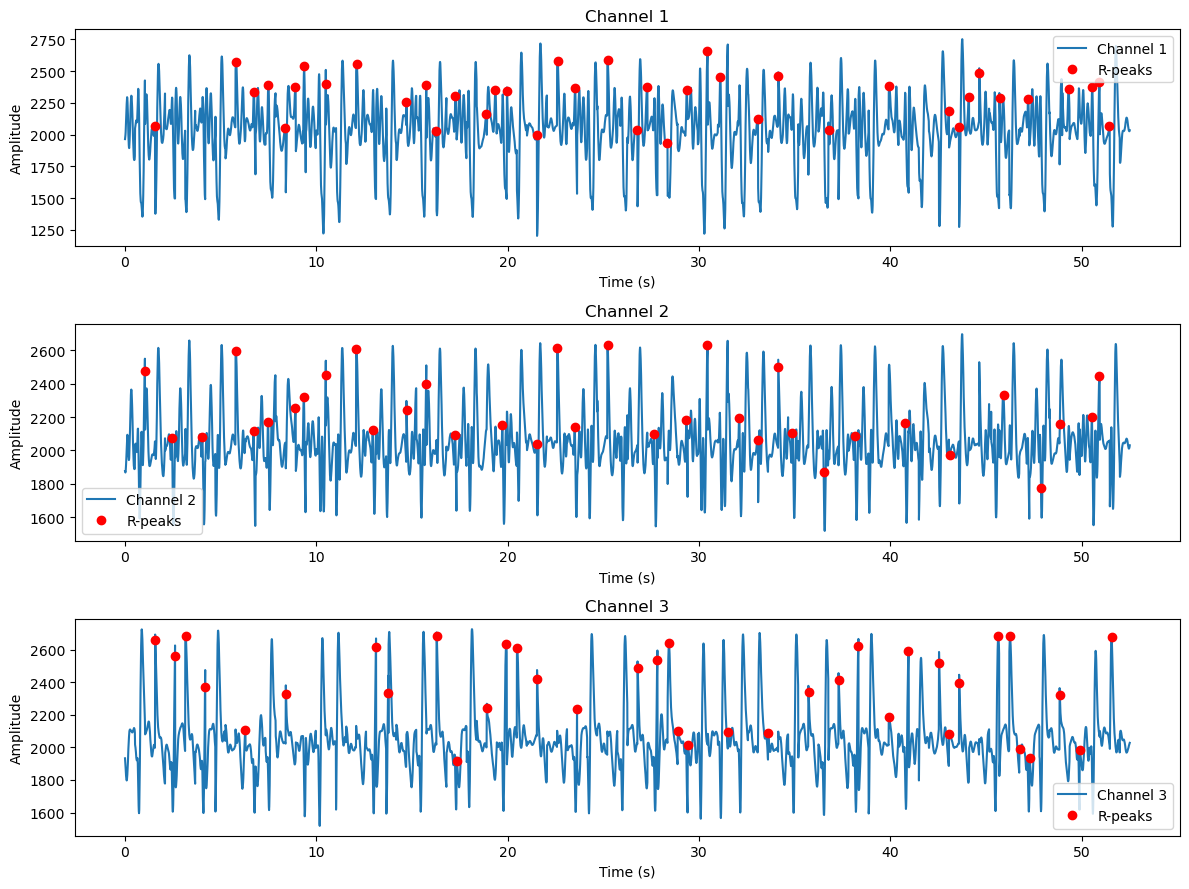

In [2]:
ecg_columns = np.s_[18:21]
ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)

framerate, frametime = di.get_dicom_framerate(dicom_folder)

kspace = di.extract_image_data(scans)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]

# For ECG processing, you need the sampling frequency.
fs = framerate * n_phase_encodes_per_frame

# Save ECG data as CSV
import pandas as pd
df = pd.DataFrame(ecg_data, columns=["ECG1", "ECG2", "ECG3"])
df['time'] = np.arange(len(ecg_data)) / fs
df.to_csv("ecg_data_MID00115.csv", index=False)

# Detect R-peaks
r_peaks_list = ecg.detect_r_peaks(ecg_data, fs)
# Compute average heart rate (for information)
hr = ecg.compute_average_heart_rate(r_peaks_list, fs)
print(f"Average heart rate: {hr:.2f} BPM")

# Plot ECG signals with R-peaks
ecg.plot_ecg_signals(ecg_data, fs, r_peaks_list, mode="separate")

Extracted ICE parameter data shape: (12800, 3)
Extracted image data shape: (12800, 30, 256)


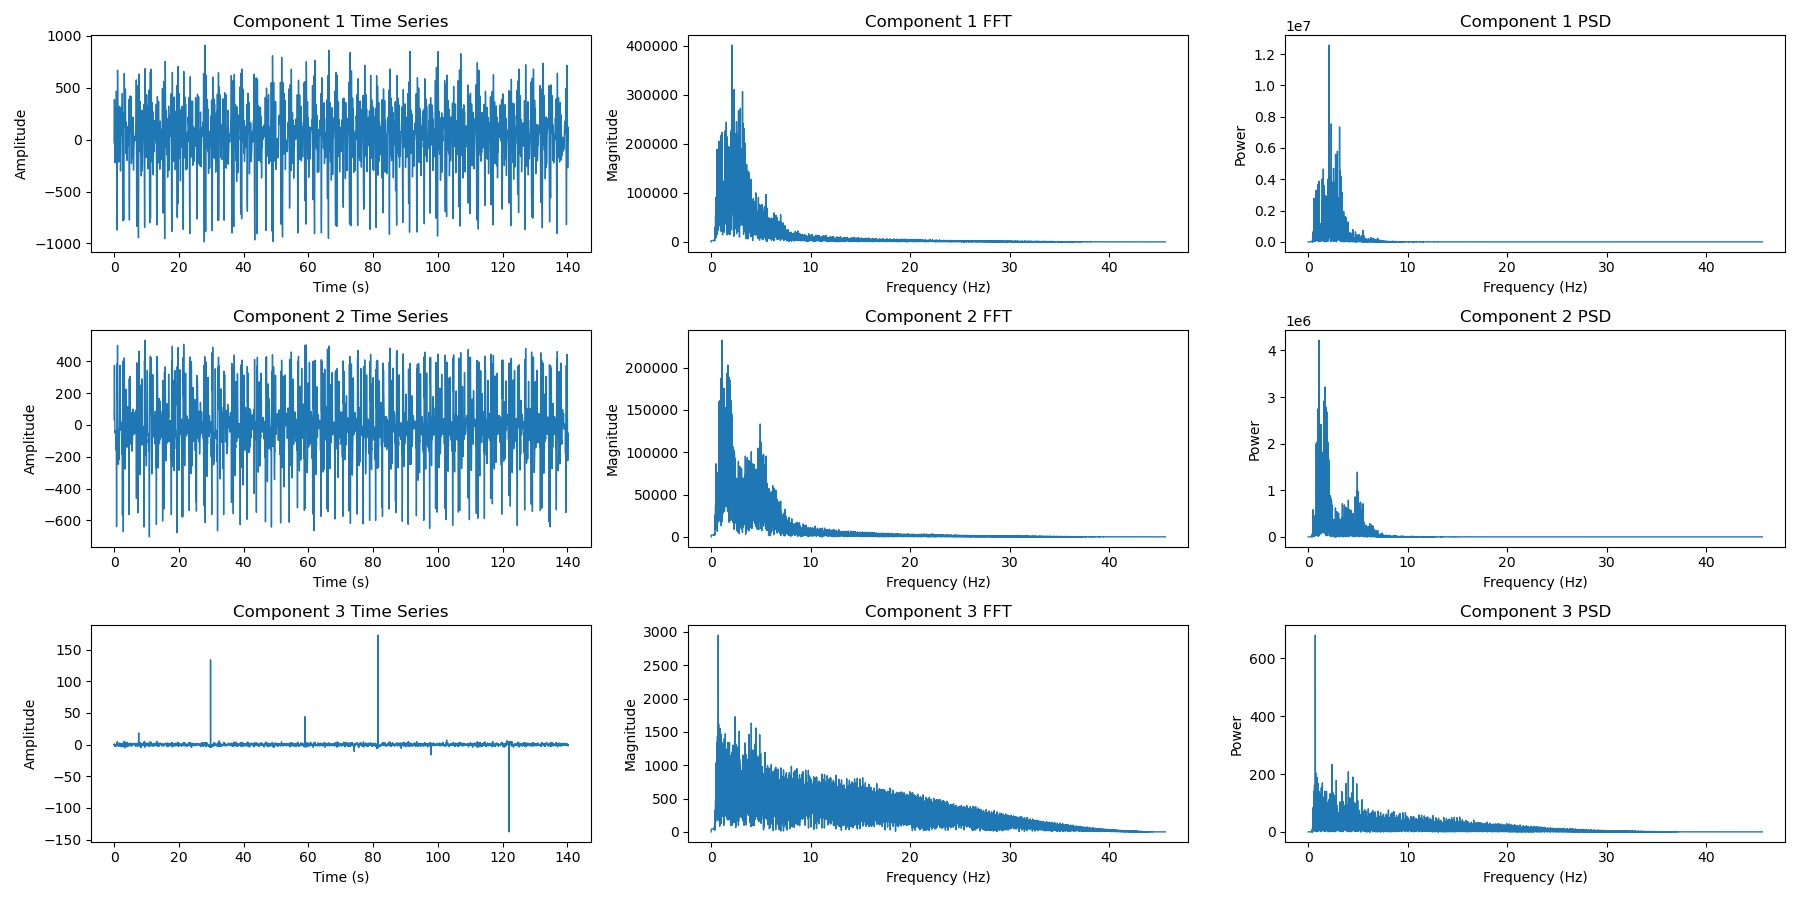

Average heart rate: 79.27 BPM


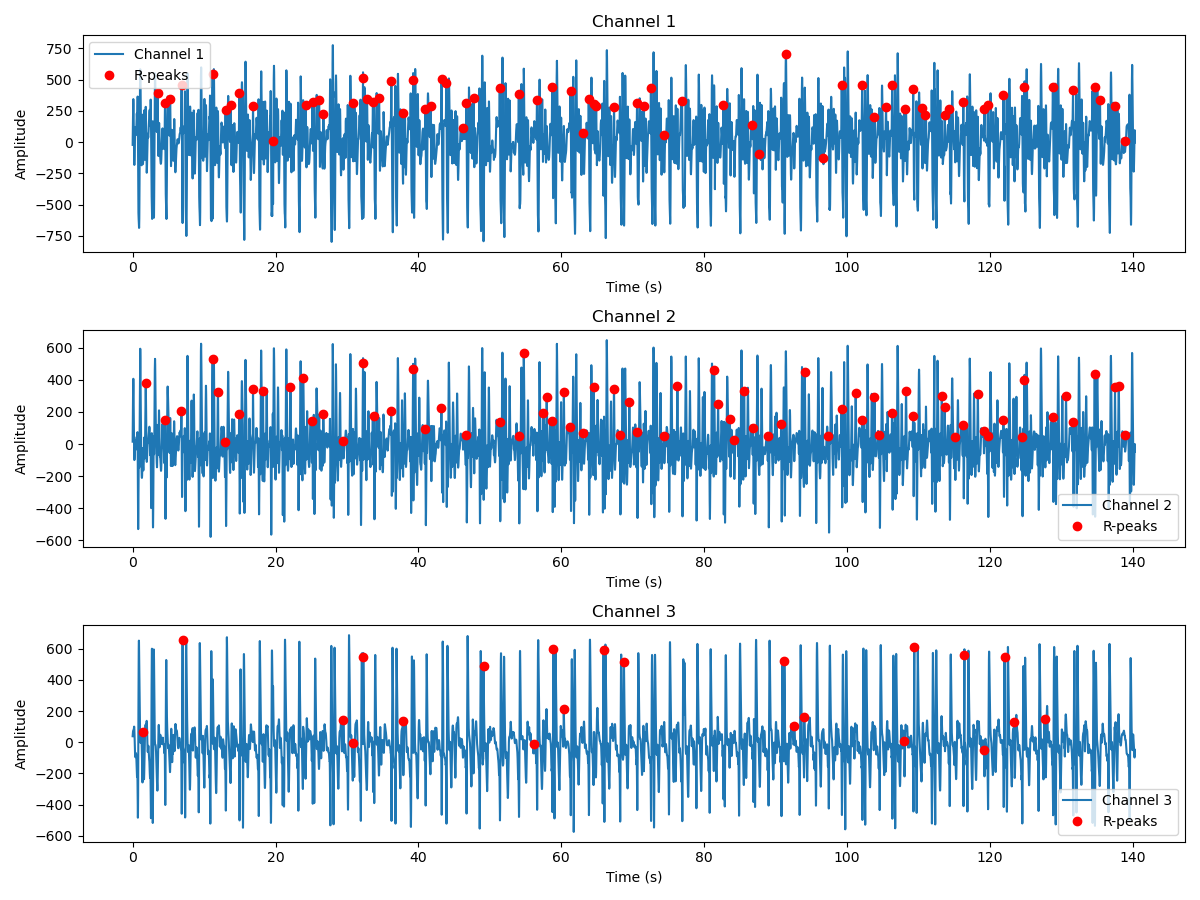

In [3]:
import neurokit2 as nk
ecg_columns = np.s_[18:21]
ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
ecg_data = np.array(ecg_data, dtype=float)
if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)

framerate, frametime = di.get_dicom_framerate(dicom_folder)

kspace = di.extract_image_data(scans)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]

# For ECG processing, you need the sampling frequency.
fs = framerate * n_phase_encodes_per_frame

for i in range(ecg_data.shape[1]):
    iv = ecg_data[:, i]
    # iv, _ = nk.ecg_invert(ecg_data[:, i], sampling_rate=fs)
    cl = nk.ecg_clean(iv, sampling_rate=fs)
    ecg_data[:, i] = cl

pca_model, X_pca, mean_vector = ecg.ecg_perform_pca(ecg_data)

ecg.plot_ecg_components_time_series_and_fft(X_pca, fs, n_components=5)

# Detect R-peaks
r_peaks_list = ecg.detect_r_peaks(ecg_data, fs)
# Compute average heart rate (for information)
hr = ecg.compute_average_heart_rate(r_peaks_list, fs)
print(f"Average heart rate: {hr:.2f} BPM")

# Plot ECG signals with R-peaks
ecg.plot_ecg_signals(ecg_data, fs, r_peaks_list, mode="separate")

Extracted ICE parameter data shape: (12800, 3)
Extracted image data shape: (12800, 30, 256)
Data resampled to 360 Hz, new length: 50504


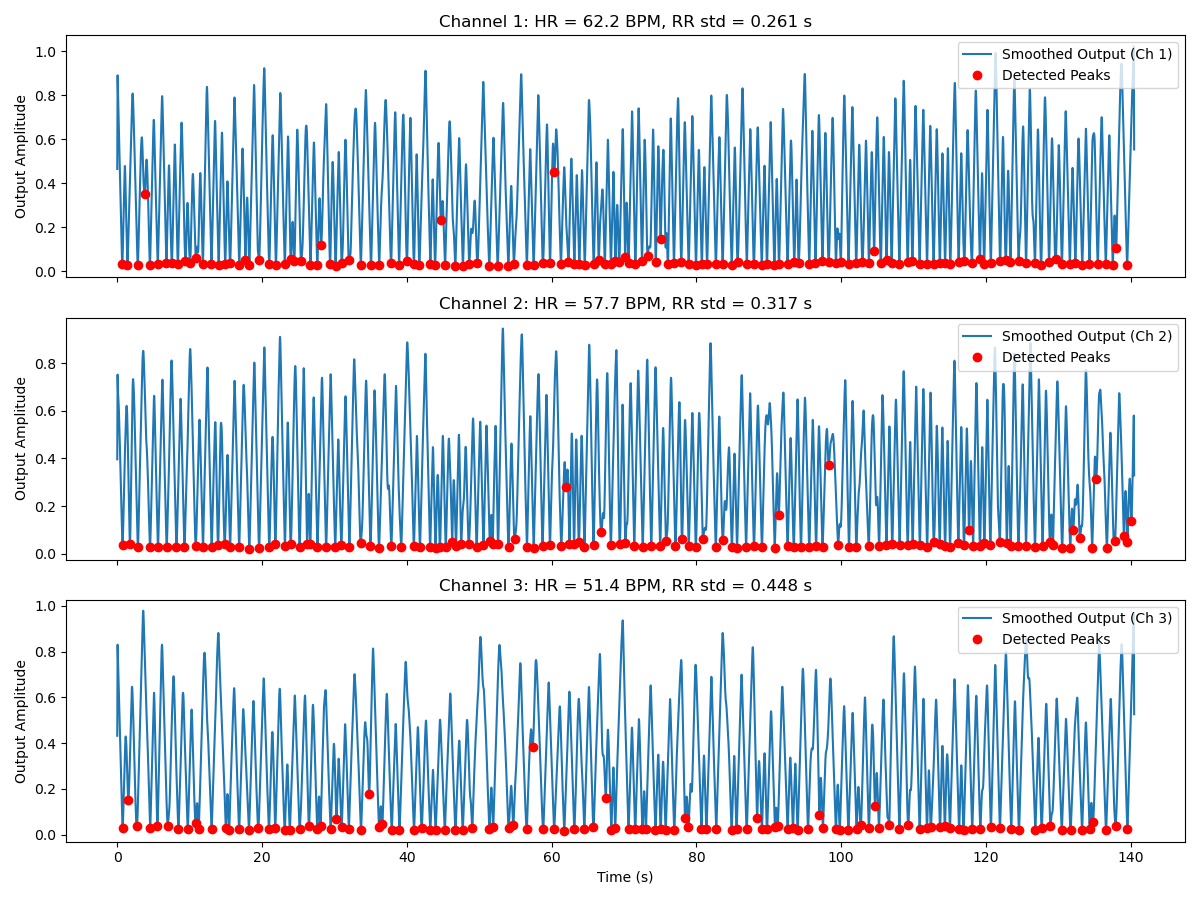

In [40]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from network2 import IncUNet
import scipy.signal
from scipy.signal import find_peaks

# ----------------------------------
# 1) LOAD AND PREPROCESS ECG DATA
# ----------------------------------
ecg_columns = np.s_[18:21]
ecg_data = di.extract_iceparam_data(scans, segment_index=0, columns=ecg_columns)
if ecg_data.ndim == 1:
    ecg_data = ecg_data.reshape(-1, 1)

# Normalize each channel
ecg_data = (ecg_data - np.mean(ecg_data, axis=0)) / np.std(ecg_data, axis=0)

framerate, _ = di.get_dicom_framerate(dicom_folder)
kspace = di.extract_image_data(scans)
n_phase_encodes_per_frame = kspace.shape[0] // config["data"]["n_frames"]
fs = framerate * n_phase_encodes_per_frame  # sampling frequency

# Store the raw (normalized) ECG data for later comparison.
raw_ecg_data = ecg_data.copy()


target_fs = 360
if fs != target_fs:
    new_length = int(ecg_data.shape[0] * target_fs / fs)
    ecg_data = scipy.signal.resample(ecg_data, new_length, axis=0)
    fs = target_fs
    print(f"Data resampled to {fs} Hz, new length: {ecg_data.shape[0]}")

# ----------------------------------
# 2) LOAD THE PRETRAINED MODEL
# ----------------------------------
model = IncUNet(in_shape=(1, None, None))
model.load_state_dict(torch.load("model.pt", map_location="cpu"))
model.eval()

# ----------------------------------
# Helper function to adjust length to meet L mod 256 = 136
# ----------------------------------
def adjust_length_to_mod(signal, mod=256, target=136):
    L = signal.shape[0]
    rem = L % mod
    pad_forward = (target - rem) % mod  
    pad_backward = pad_forward - mod if pad_forward != 0 else 0  
    adjustment = pad_forward if abs(pad_forward) <= abs(pad_backward) else pad_backward
    if adjustment > 0:
        signal_adj = np.pad(signal, (0, adjustment), mode='reflect')
    elif adjustment < 0:
        signal_adj = signal[:L + adjustment]
    else:
        signal_adj = signal
    return signal_adj

# ----------------------------------
# 3) PROCESS EACH CHANNEL INDIVIDUALLY AND COMPUTE HR METRICS
# ----------------------------------
n_channels = ecg_data.shape[1]
fig, axs = plt.subplots(n_channels, 1, figsize=(12, 3 * n_channels), sharex=True)
if n_channels == 1:
    axs = [axs]

# Create a list to store model-detected peak indices for each channel.
model_peak_indices = []

for ch in range(n_channels):
    # Extract single-channel ECG (shape: (n_samples,))
    single_channel = ecg_data[:, ch]
    # Adjust length to satisfy L mod 256 = 136
    single_channel_adj = adjust_length_to_mod(single_channel, mod=256, target=136)
    single_channel_adj = nk.ecg_clean(nk.ecg_invert(single_channel_adj, sampling_rate=fs)[0], sampling_rate=fs).copy()
    L_adj = single_channel_adj.shape[0]
    
    # Prepare input for IncUNet: shape (1, 1, L_adj)
    ecg_tensor = torch.from_numpy(single_channel_adj[None, None, :]).float()
    
    # Model forward pass
    with torch.no_grad():
        output = model(ecg_tensor)
    predictions = output.squeeze().cpu().numpy()  # shape (L_adj,)
    
    # Smooth the predictions
    window_size = max(1, int(0.1 * fs))  # e.g., 0.1 second window
    predictions_smooth = np.convolve(predictions, np.ones(window_size)/window_size, mode='same')
    
    # Robust peak detection using distance and prominence parameters.
    # Note: In this code we use find_peaks on the negative smoothed output, as in your code.
    distance_samples = int(0.3 * fs)  # ~300 ms minimum distance
    prominence_threshold = 0.05  # adjust as needed
    peak_indices, properties = find_peaks(-predictions_smooth, distance=distance_samples, prominence=prominence_threshold)
    
    # Save the detected peak indices for later use
    model_peak_indices.append(peak_indices)
    
    # Compute quantitative heart rate metrics if peaks are found
    if len(peak_indices) > 1:
        rr_intervals = np.diff(peak_indices) / fs  # in seconds
        avg_rr = np.mean(rr_intervals)
        heart_rate = 60.0 / avg_rr  # BPM
        hr_std = np.std(rr_intervals)
    else:
        heart_rate = np.nan
        hr_std = np.nan
    
    # Define time axis based on adjusted length
    time_axis = np.arange(L_adj) / fs
    
    # Plot the smoothed output with detected peaks for this channel
    axs[ch].plot(time_axis, predictions_smooth, label=f"Smoothed Output (Ch {ch+1})")
    axs[ch].plot(time_axis[peak_indices], predictions_smooth[peak_indices],
                 "ro", label="Detected Peaks")
    axs[ch].set_ylabel("Output Amplitude")
    axs[ch].legend(loc="upper right")
    axs[ch].set_title(f"Channel {ch+1}: HR = {heart_rate:.1f} BPM, RR std = {hr_std:.3f} s")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

Channel 1 is inverted: True
Channel 2 is inverted: False
Channel 3 is inverted: False


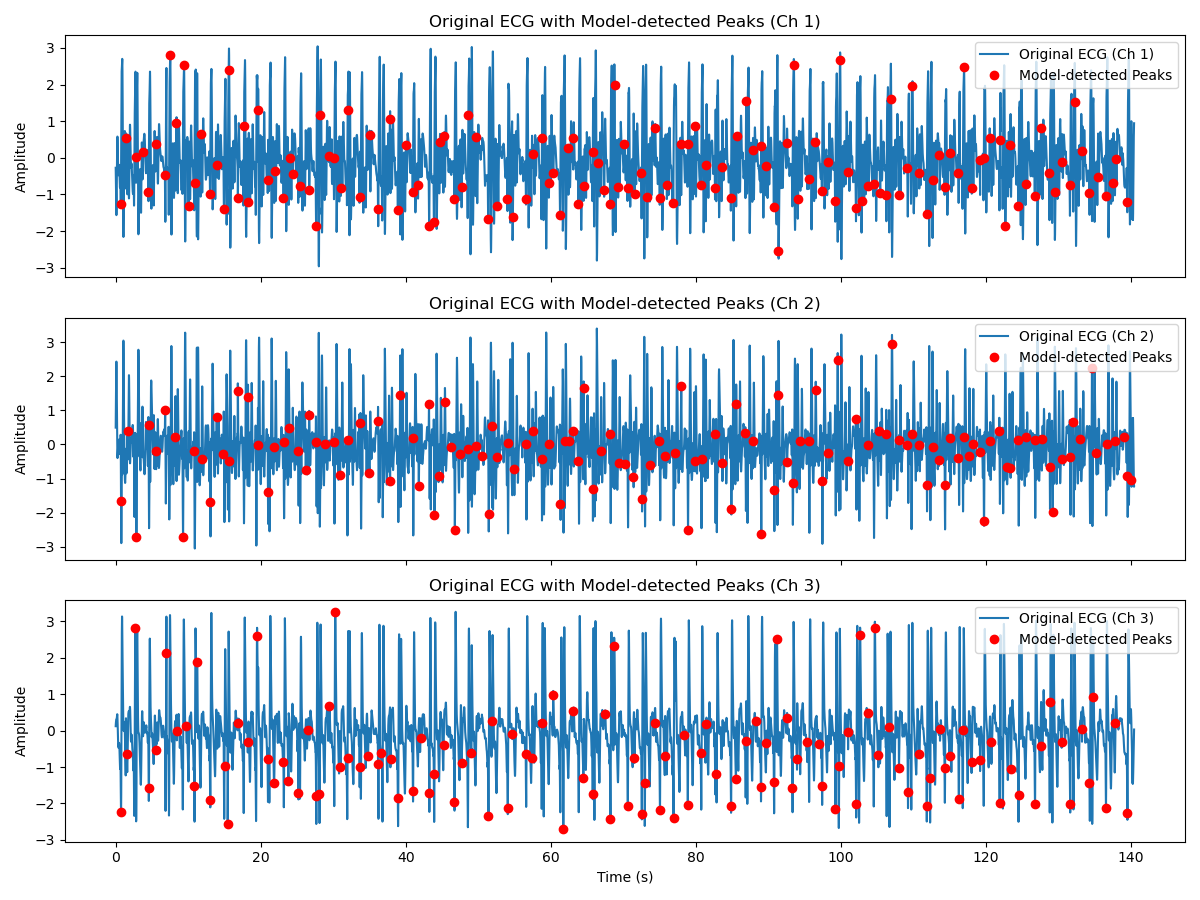

In [41]:
import neurokit2 as nk



# ----- NEW PLOT: ORIGINAL ECG with Model-detected Peaks -----
fig2, axs2 = plt.subplots(n_channels, 1, figsize=(12, 3 * n_channels), sharex=True)
if n_channels == 1:
    axs2 = [axs2]

for ch in range(n_channels):
    # Get the original single-channel ECG from the (upsampled) ecg_data
    original_signal = ecg_data[:, ch]
    original_signal, inverted = nk.ecg_invert(original_signal)  # Invert if needed
    print(f"Channel {ch+1} is inverted: {inverted}")
    original_signal = nk.ecg_clean(nk.ecg_invert(original_signal, sampling_rate=fs)[0], sampling_rate=fs)
    # Adjust its length to satisfy L mod 256 = 136 (same as before)
    original_adj = adjust_length_to_mod(original_signal, mod=256, target=136)
    L_adj = original_adj.shape[0]
    time_axis = np.arange(L_adj) / fs

    # Use the stored model-detected peak indices from this channel
    peak_indices_model = model_peak_indices[ch]
    
    axs2[ch].plot(time_axis, original_adj, label=f"Original ECG (Ch {ch+1})", color='C0')
    axs2[ch].plot(time_axis[peak_indices_model], original_adj[peak_indices_model], 
                 "ro", label="Model-detected Peaks")
    axs2[ch].set_ylabel("Amplitude")
    axs2[ch].legend(loc="upper right")
    axs2[ch].set_title(f"Original ECG with Model-detected Peaks (Ch {ch+1})")

axs2[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [17]:
class Pan_Tompkins_QRS():
  
  def band_pass_filter(self,signal):
    '''
    Band Pass Filter
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    Bandpass filter is used to attenuate the noise in the input signal.
    To acheive a passband of 5-15 Hz, the input signal is first passed 
    through a low pass filter having a cutoff frequency of 11 Hz and then
    through a high pass filter with a cutoff frequency of 5 Hz, thus
    achieving the required thresholds. 

    The low pass filter has the recursive equation:
      y(nT) = 2y(nT - T) - y(nT - 2T) + x(nT) - 2x(nT - 6T) + x(nT - 12T)

    The high pass filter has the recursive equation:
      y(nT) = 32x(nT - 16T) - y(nT - T) - x(nT) + x(nT - 32T)
    '''

    # Initialize result
    result = None

    # Create a copy of the input signal
    sig = signal.copy()
	
    # Apply the low pass filter using the equation given
    for index in range(len(signal)):
      sig[index] = signal[index]

      if (index >= 1):
        sig[index] += 2*sig[index-1]

      if (index >= 2):
        sig[index] -= sig[index-2]

      if (index >= 6):
        sig[index] -= 2*signal[index-6]

      if (index >= 12):
        sig[index] += signal[index-12] 
	
    # Copy the result of the low pass filter
    result = sig.copy()

    # Apply the high pass filter using the equation given
    for index in range(len(signal)):
      result[index] = -1*sig[index]

      if (index >= 1):
        result[index] -= result[index-1]

      if (index >= 16):
        result[index] += 32*sig[index-16]

      if (index >= 32):
        result[index] += sig[index-32]

    # Normalize the result from the high pass filter
    max_val = max(max(result),-min(result))
    result = result/max_val

    return result

  def derivative(self,signal):
    '''
    Derivative Filter 
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The derivative of the input signal is taken to obtain the
    information of the slope of the signal. Thus, the rate of change
    of input is obtain in this step of the algorithm.

    The derivative filter has the recursive equation:
      y(nT) = [-x(nT - 2T) - 2x(nT - T) + 2x(nT + T) + x(nT + 2T)]/(8T)
    '''

    # Initialize result
    result = signal.copy()

    # Apply the derivative filter using the equation given
    for index in range(len(signal)):
      result[index] = 0

      if (index >= 1):
        result[index] -= 2*signal[index-1]

      if (index >= 2):
        result[index] -= signal[index-2]

      if (index >= 2 and index <= len(signal)-2):
        result[index] += 2*signal[index+1]

      if (index >= 2 and index <= len(signal)-3):
        result[index] += signal[index+2]

      result[index] = (result[index]*annotation.fs)/8

    return result

  def squaring(self,signal):
    '''
    Squaring the Signal
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The squaring process is used to intensify the slope of the
    frequency response curve obtained in the derivative step. This
    step helps in restricting false positives which may be caused
    by T waves in the input signal.

    The squaring filter has the recursive equation:
      y(nT) = [x(nT)]^2
    '''

    # Initialize result
    result = signal.copy()

    # Apply the squaring using the equation given
    for index in range(len(signal)):
      result[index] = signal[index]**2

    return result    

  def moving_window_integration(self,signal):
    '''
    Moving Window Integrator
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The moving window integration process is done to obtain
    information about both the slope and width of the QRS complex.
    A window size of 0.15*(sample frequency) is used for more
    accurate results.

    The moving window integration has the recursive equation:
      y(nT) = [y(nT - (N-1)T) + x(nT - (N-2)T) + ... + x(nT)]/N

      where N is the number of samples in the width of integration
      window.
    '''

    # Initialize result and window size for integration
    result = signal.copy()
    win_size = round(0.150 * annotation.fs)
    sum = 0

    # Calculate the sum for the first N terms
    for j in range(win_size):
      sum += signal[j]/win_size
      result[j] = sum
    
    # Apply the moving window integration using the equation given
    for index in range(win_size,len(signal)):  
      sum += signal[index]/win_size
      sum -= signal[index-win_size]/win_size
      result[index] = sum

    return result

  def solve(self,signal):
    '''
    Solver, Combines all the above functions
    :param signal: input signal
    :return: prcoessed signal

    Methodology/Explaination:
    The peak detection algorithm works on the moving window and bandpass
    filtered signal. So the input signal is first bandpassed, then the
    output of the bandpass filter is given to the derivative function and
    the result is squared. Finally the output of the squaring function
    is given to the moving window integration function and returned. 
    '''

    # Convert the input signal into numpy array
    input_signal = signal.iloc[:,1].to_numpy()

    # Bandpass Filter
    global bpass
    bpass = self.band_pass_filter(input_signal.copy())

    # Derivative Function
    global der
    der = self.derivative(bpass.copy())

    # Squaring Function
    global sqr
    sqr = self.squaring(der.copy())

    # Moving Window Integration Function
    global mwin
    mwin = self.moving_window_integration(sqr.copy())

    return mwin
  
class heart_rate():

  def __init__(self,signal,samp_freq):
    '''
    Initialize Variables
    :param signal: input signal
    :param samp_freq: sample frequency of input signal
    '''

    # Initialize variables
    self.RR1, self.RR2, self.probable_peaks, self.r_locs, self.peaks, self.result = ([] for i in range(6))
    self.SPKI, self.NPKI, self.Threshold_I1, self.Threshold_I2, self.SPKF, self.NPKF, self.Threshold_F1, self.Threshold_F2 = (0 for i in range(8))

    self.T_wave = False          
    self.m_win = mwin
    self.b_pass = bpass
    self.samp_freq = samp_freq
    self.signal = signal
    self.win_150ms = round(0.15*self.samp_freq)

    self.RR_Low_Limit = 0
    self.RR_High_Limit = 0
    self.RR_Missed_Limit = 0
    self.RR_Average1 = 0


  def approx_peak(self):
    '''
    Approximate peak locations
    '''   

    # FFT convolution
    slopes = sg.fftconvolve(self.m_win, np.full((25,), 1) / 25, mode='same')

    # Finding approximate peak locations
    for i in range(round(0.5*self.samp_freq) + 1,len(slopes)-1):
        if (slopes[i] > slopes[i-1]) and (slopes[i+1] < slopes[i]):
            self.peaks.append(i)  


  def adjust_rr_interval(self,ind):
    '''
    Adjust RR Interval and Limits
    :param ind: current index in peaks array
    '''

    # Finding the eight most recent RR intervals
    self.RR1 = np.diff(self.peaks[max(0,ind - 8) : ind + 1])/self.samp_freq   

    # Calculating RR Averages
    self.RR_Average1 = np.mean(self.RR1)
    RR_Average2 = self.RR_Average1
      
    # Finding the eight most recent RR intervals lying between RR Low Limit and RR High Limit  
    if (ind >= 8):
        for i in range(0, 8):
            if (self.RR_Low_Limit < self.RR1[i] < self.RR_High_Limit): 
                self.RR2.append(self.RR1[i])

                if (len(self.RR2) > 8):
                    self.RR2.remove(self.RR2[0])
                    RR_Average2 = np.mean(self.RR2)    

    # Adjusting the RR Low Limit and RR High Limit
    if (len(self.RR2) > 7 or ind < 8):
        self.RR_Low_Limit = 0.92 * RR_Average2        
        self.RR_High_Limit = 1.16 * RR_Average2
        self.RR_Missed_Limit = 1.66 * RR_Average2


  def searchback(self,peak_val,RRn,sb_win):
      '''
      Searchback
      :param peak_val: peak location in consideration
      :param RRn: the most recent RR interval
      :param sb_win: searchback window
      '''

      # Check if the most recent RR interval is greater than the RR Missed Limit
      if (RRn > self.RR_Missed_Limit):
          # Initialize a window to searchback  
          win_rr = self.m_win[peak_val - sb_win + 1 : peak_val + 1] 

          # Find the x locations inside the window having y values greater than Threshold I1             
          coord = np.asarray(win_rr > self.Threshold_I1).nonzero()[0]

          # Find the x location of the max peak value in the search window
          if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      x_max = pos
                      break
          else:
            x_max = None
 
          # If the max peak value is found
          if (x_max is not None):   
            # Update the thresholds corresponding to moving window integration
            self.SPKI = 0.25 * self.m_win[x_max] + 0.75 * self.SPKI                         
            self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
            self.Threshold_I2 = 0.5 * self.Threshold_I1         

            # Initialize a window to searchback 
            win_rr = self.b_pass[x_max - self.win_150ms: min(len(self.b_pass) -1, x_max)]  

            # Find the x locations inside the window having y values greater than Threshold F1                   
            coord = np.asarray(win_rr > self.Threshold_F1).nonzero()[0]

            # Find the x location of the max peak value in the search window
            if (len(coord) > 0):
              for pos in coord:
                  if (win_rr[pos] == max(win_rr[coord])):
                      r_max = pos
                      break
            else:
              r_max = None

            # If the max peak value is found
            if (r_max is not None):
              # Update the thresholds corresponding to bandpass filter
              if self.b_pass[r_max] > self.Threshold_F2:                                                        
                  self.SPKF = 0.25 * self.b_pass[r_max] + 0.75 * self.SPKF                            
                  self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
                  self.Threshold_F2 = 0.5 * self.Threshold_F1      

                  # Append the probable R peak location                      
                  self.r_locs.append(r_max)                                                


  def find_t_wave(self,peak_val,RRn,ind,prev_ind):
    '''
    T Wave Identification
    :param peak_val: peak location in consideration
    :param RRn: the most recent RR interval
    :param ind: current index in peaks array
    :param prev_ind: previous index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        if (ind > 0 and 0.20 < RRn < 0.36):
          # Find the slope of current and last waveform detected        
          curr_slope = max(np.diff(self.m_win[peak_val - round(self.win_150ms/2) : peak_val + 1]))
          last_slope = max(np.diff(self.m_win[self.peaks[prev_ind] - round(self.win_150ms/2) : self.peaks[prev_ind] + 1]))
          
          # If current waveform slope is less than half of last waveform slope
          if (curr_slope < 0.5*last_slope):  
              # T Wave is found and update noise threshold                      
              self.T_wave = True                             
              self.NPKI = 0.125 * self.m_win[peak_val] + 0.875 * self.NPKI 

        if (not self.T_wave):
            # T Wave is not found and update signal thresholds
            if (self.probable_peaks[ind] > self.Threshold_F1):   
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI                                         
                self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

                # Append the probable R peak location
                self.r_locs.append(self.probable_peaks[ind])  

            else:
                self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI
                self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                   

    # Update noise thresholds
    elif (self.m_win[peak_val] < self.Threshold_I1) or (self.Threshold_I1 < self.m_win[peak_val] < self.Threshold_I2):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def adjust_thresholds(self,peak_val,ind):
    '''
    Adjust Noise and Signal Thresholds During Learning Phase
    :param peak_val: peak location in consideration
    :param ind: current index in peaks array
    '''

    if (self.m_win[peak_val] >= self.Threshold_I1): 
        # Update signal threshold
        self.SPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.SPKI

        if (self.probable_peaks[ind] > self.Threshold_F1):                                            
            self.SPKF = 0.125 * self.b_pass[ind] + 0.875 * self.SPKF 

            # Append the probable R peak location
            self.r_locs.append(self.probable_peaks[ind])  

        else:
            # Update noise threshold
            self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF                                    
        
    # Update noise thresholds    
    elif (self.m_win[peak_val] < self.Threshold_I2) or (self.Threshold_I2 < self.m_win[peak_val] < self.Threshold_I1):
        self.NPKI = 0.125 * self.m_win[peak_val]  + 0.875 * self.NPKI  
        self.NPKF = 0.125 * self.b_pass[ind] + 0.875 * self.NPKF


  def update_thresholds(self):
    '''
    Update Noise and Signal Thresholds for next iteration
    '''

    self.Threshold_I1 = self.NPKI + 0.25 * (self.SPKI - self.NPKI)
    self.Threshold_F1 = self.NPKF + 0.25 * (self.SPKF - self.NPKF)
    self.Threshold_I2 = 0.5 * self.Threshold_I1 
    self.Threshold_F2 = 0.5 * self.Threshold_F1
    self.T_wave = False 


  def ecg_searchback(self):
    '''
    Searchback in ECG signal to increase efficiency
    '''

    # Filter the unique R peak locations
    self.r_locs = np.unique(np.array(self.r_locs).astype(int))

    # Initialize a window to searchback
    win_200ms = round(0.2*self.samp_freq)
   
    for r_val in self.r_locs:
        coord = np.arange(r_val - win_200ms, min(len(self.signal), r_val + win_200ms + 1), 1)

        # Find the x location of the max peak value
        if (len(coord) > 0):
          for pos in coord:
              if (self.signal[pos] == max(self.signal[coord])):
                  x_max = pos
                  break
        else:
          x_max = None

        # Append the peak location
        if (x_max is not None):   
          self.result.append(x_max)


  def find_r_peaks(self):
    '''
    R Peak Detection
    '''

    # Find approximate peak locations
    self.approx_peak()

    # Iterate over possible peak locations
    for ind in range(len(self.peaks)):

        # Initialize the search window for peak detection
        peak_val = self.peaks[ind]
        win_300ms = np.arange(max(0, self.peaks[ind] - self.win_150ms), min(self.peaks[ind] + self.win_150ms, len(self.b_pass)-1), 1)
        max_val = max(self.b_pass[win_300ms], default = 0)

        # Find the x location of the max peak value
        if (max_val != 0):        
          x_coord = np.asarray(self.b_pass == max_val).nonzero()
          self.probable_peaks.append(x_coord[0][0])
        
        if (ind < len(self.probable_peaks) and ind != 0):
            # Adjust RR interval and limits
            self.adjust_rr_interval(ind)
            
            # Adjust thresholds in case of irregular beats
            if (self.RR_Average1 < self.RR_Low_Limit or self.RR_Average1 > self.RR_Missed_Limit): 
                self.Threshold_I1 /= 2
                self.Threshold_F1 /= 2

            RRn = self.RR1[-1]

            # Searchback
            self.searchback(peak_val,RRn,round(RRn*self.samp_freq))

            # T Wave Identification
            self.find_t_wave(peak_val,RRn,ind,ind-1)

        else:
          # Adjust threholds
          self.adjust_thresholds(peak_val,ind)

        # Update threholds for next iteration
        self.update_thresholds()

    # Searchback in ECG signal 
    self.ecg_searchback()

    return self.result

/var/folders/px/wy4h6r3d0pjcgpg5tm4lrp9h0000gn/T/ipykernel_98673/3717129227.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(n_channels, 1, figsize=(20, 4 * n_channels), sharex=True)


Channel 1 Pan-Tompkins Detected HR: 91.1 BPM
Channel 2 Pan-Tompkins Detected HR: 79.0 BPM
Channel 3 Pan-Tompkins Detected HR: 40.4 BPM


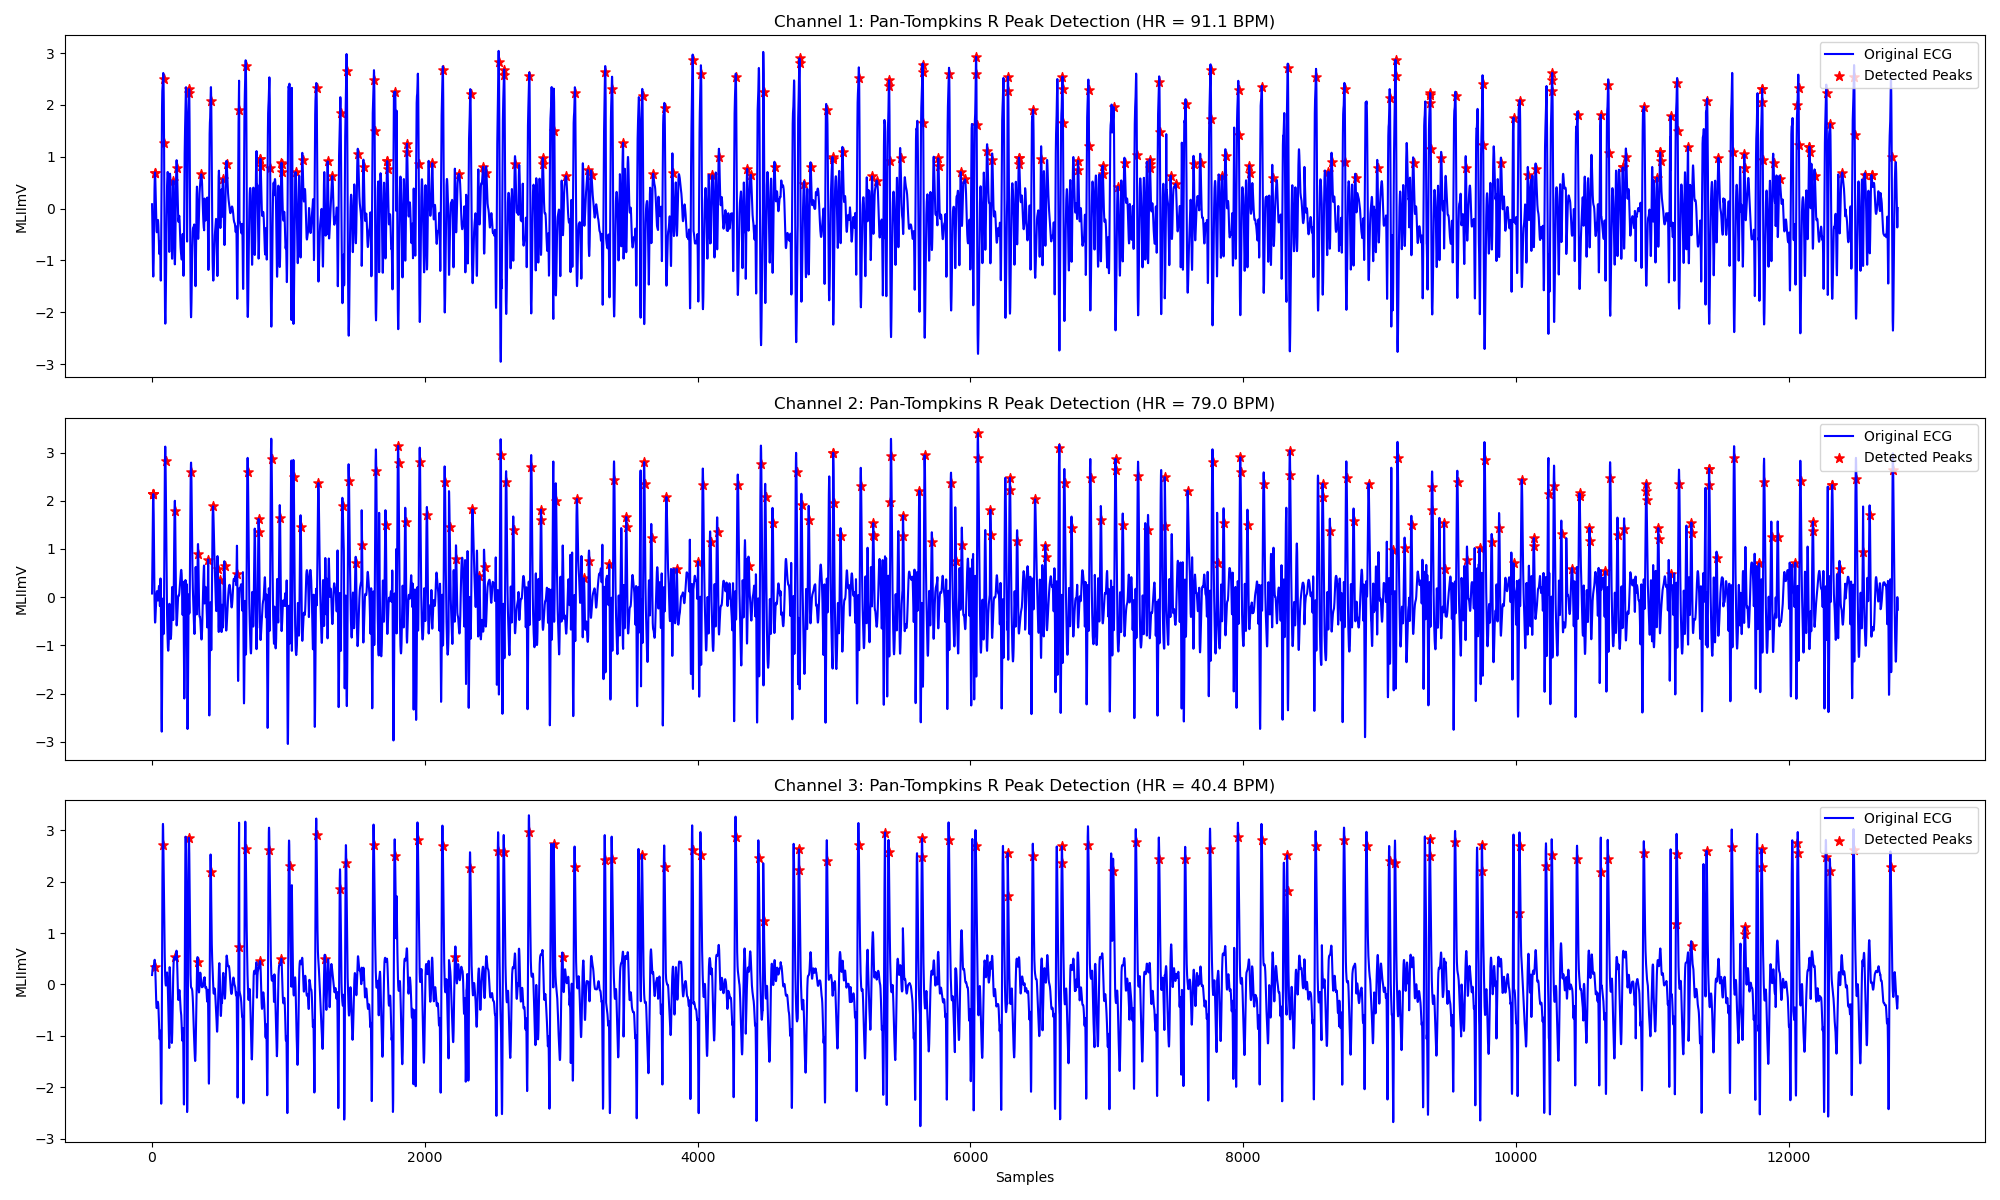

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal as sg

# Process all channels
n_channels = ecg_data.shape[1]

# Create a dummy annotation object so that annotation.fs can be used in the Pan-Tompkins code.
class DummyAnnotation:
    pass
annotation = DummyAnnotation()
annotation.fs = fs  # Use our previously defined sampling frequency

# Prepare lists to store results for each channel
all_r_peaks = []
all_hr = []

# Create subplots to show the original ECG with detected peaks for each channel
fig, axs = plt.subplots(n_channels, 1, figsize=(20, 4 * n_channels), sharex=True)
if n_channels == 1:
    axs = [axs]

for ch in range(n_channels):
    # Create a DataFrame for channel 'ch'
    ecg_df = pd.DataFrame({
        'TimeStamp': np.arange(ecg_data.shape[0]),
        'ecg': nk.ecg_clean(nk.ecg_invert(ecg_data[:, ch], sampling_rate=fs)[0], sampling_rate=fs)
    })
    
    # Instantiate the Pan-Tompkins detector and process the signal.
    QRS_detector = Pan_Tompkins_QRS()
    pt_output = QRS_detector.solve(ecg_df)  # This sets globals bpass, der, sqr, and mwin
    
    # Use the heart_rate class to detect R peaks.
    hr_detector = heart_rate(ecg_df, fs)
    # Convert to NumPy array if signal is a DataFrame
    if hasattr(hr_detector.signal, 'columns'):
        hr_detector.signal = hr_detector.signal['ecg'].to_numpy()
    r_peaks = hr_detector.find_r_peaks()
    r_peaks = np.array(r_peaks)
    r_peaks = r_peaks[r_peaks > 0]  # only use positive indices
    all_r_peaks.append(r_peaks)
    
    # Compute heart rate if possible
    if len(r_peaks) > 1:
        computed_hr = (60 * fs) / np.average(np.diff(r_peaks))
    else:
        computed_hr = np.nan
    all_hr.append(computed_hr)
    print(f"Channel {ch+1} Pan-Tompkins Detected HR: {computed_hr:.1f} BPM")
    
    # Plot original ECG signal with detected peaks for this channel
    axs[ch].plot(ecg_df['ecg'], color='blue', label='Original ECG')
    axs[ch].scatter(r_peaks, ecg_df['ecg'].iloc[r_peaks], color='red', s=50, marker='*', label='Detected Peaks')
    axs[ch].set_ylabel('MLIImV')
    axs[ch].legend(loc='upper right')
    axs[ch].set_title(f"Channel {ch+1}: Pan-Tompkins R Peak Detection (HR = {computed_hr:.1f} BPM)")

axs[-1].set_xlabel('Samples')
plt.tight_layout()
plt.show()